In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier

# TensorFlow/Keras för ANN-modeller
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

# Keras Tuner för hyperparameter-optimering
import keras_tuner as kt

# 1: Ladda up datasetet

In [163]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()

# 2: Kollar vad som finns i datan

In [164]:
print(f"Antal klasser: {len(np.unique(Y_train))}")

Antal klasser: 10


#### X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42) behövs inte längre eftersom mnist.load_data() redan ger träningsdata och testdata 

# 3: Normalisera data
### Normalisera pixelvärdena från (0-255) till (0-1) för bättre träning

In [165]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# 4: plattar till bilderna till 1D för ANN modellen inte kan läsa 2D bilder

In [166]:
X_train = X_train.reshape(X_train.shape[0], 28 * 28)
X_test = X_test.reshape(X_test.shape[0], 28 * 28)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (60000, 784)
X_test shape: (10000, 784)


# 5: Bygga ANN-modellen 

In [167]:
model = Sequential()
model.add(Input(shape=(784,)))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))

model.add(Dense(10, activation = 'softmax'))

### 5.2: Konfigurera modellen

In [168]:
model.compile(optimizer = 'adam', loss = 'SparseCategoricalCrossentropy', metrics = ['accuracy'])

# 6: Tränar modellen "EarlyStopping(patience = 2)"

In [169]:
early_stopping_monitor = EarlyStopping(patience = 2)
model_trained = model.fit(X_train, Y_train, validation_split = 0.2, epochs = 100, callbacks = [early_stopping_monitor])

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 796us/step - accuracy: 0.8662 - loss: 0.4734 - val_accuracy: 0.9585 - val_loss: 0.1350
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step - accuracy: 0.9642 - loss: 0.1176 - val_accuracy: 0.9645 - val_loss: 0.1156
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step - accuracy: 0.9765 - loss: 0.0765 - val_accuracy: 0.9731 - val_loss: 0.0934
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 716us/step - accuracy: 0.9833 - loss: 0.0549 - val_accuracy: 0.9718 - val_loss: 0.0940
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step - accuracy: 0.9858 - loss: 0.0437 - val_accuracy: 0.9715 - val_loss: 0.0962


# 7: Kolla på träningshistoriken

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


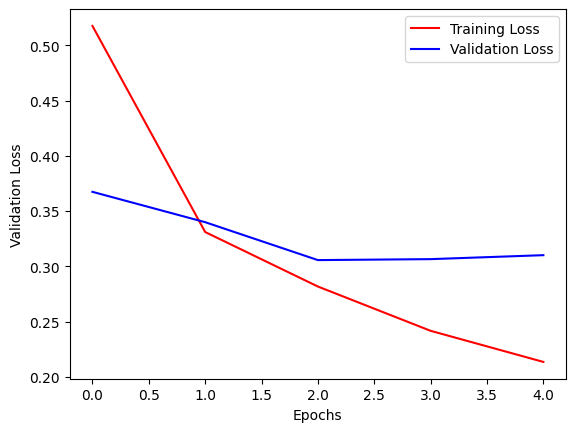

In [170]:
print(model_trained.history.keys())

plt.plot(np.sqrt(model_trained.history['loss']), 'r', label='Training Loss')
plt.plot(np.sqrt(model_trained.history['val_loss']), 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()

# 8: Implementerar KerasTuner

In [172]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(784,)))
    
    # Hyperparameter: Antal neuroner i första lagret
    # Söker mellan 32 och 256 neuroner i steg om 32
    units_layer1 = hp.Int('units_layer1', min_value=32, max_value=256, step=32)
    model.add(Dense(units=units_layer1, activation='relu'))
    
    # Andra lagret kan också optimeras
    units_layer2 = hp.Int('units_layer2', min_value=32, max_value=128, step=32)
    model.add(Dense(units=units_layer2, activation='relu'))
    
    # Output-lager
    model.add(Dense(10, activation='softmax'))
    
    model.compile(
        optimizer='adam',
        loss='SparseCategoricalCrossentropy',
        metrics=['accuracy']
    )
    
    return model

## 8.2: Nu vill vi starta KerasTuner

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',  # Vi vill maximera träffsäkerheten
    max_trials=5,              # Hur många olika parametrar ska den testa?
    directory='my_dir',        
    project_name='mnist_tuning'
)
tuner.search(X_train, Y_train, epochs=5, validation_data=(X_test, Y_test))

# Hämtar den bästa modellen
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Det bästa antalet neuroner i lager 1 var: {best_hps.get('units_layer2')}")
print(f"Det bästa antalet neuroner i lager 2 var: {best_hps.get('units_layer1')}")

Reloading Tuner from my_dir/mnist_tuning/tuner0.json
Det bästa antalet neuroner i lager 1 var: 128
Det bästa antalet neuroner i lager 2 var: 64


/Users/namiandisheh/Library/Python/3.9/lib/python/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
